### Проверка правильности работы загрузчика данных с аугментацией

In [4]:
import pandas as pd
import os
import glob
import cv2
import torch
from torchinfo import summary
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import math
from torch.optim.lr_scheduler import ExponentialLR
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
from typing import Tuple
import sys
from sklearn.metrics import accuracy_score

from config import (
    verbose, 
    model_type, 
    image_height, 
    image_width, 
    treashold,
    num_workers
    )

from lib.wrapper import ModelWrapper
from lib.dataset import KeypointDataset
from lib.mobilenet import MobileKeypointNet

In [5]:
def visualize_batch(images: torch.Tensor, landmarks: torch.Tensor, size: int = 14, 
                    shape: tuple = (6, 6), title: str = None, save: bool = None):
    '''Функция проверки правильной работы пайплайна предобработки данных перед подачей в нейронную сеть
    (с учетом аугментации) на основе сформированного батча путем вывода на экран изображений, находящихся в батче,
    и соответствующих им ключевых точек
    Входные параметры:
    images: torch.Tensor - батч изображений
    landmarks: torch.Tensor - батч координат ключевых точек
    size: int - размер фигуры для отрисовки изображений и ключевых точек
    shape: tuple - число ячеек по горизонтали и вертикали, в которых будут изображения
    title: str - заголовок
    save: bool - флаг сохранения'''
    
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images, landmarks):
        landmarks = landmarks.view(-1, 2)
        landmarks = landmarks.numpy()
        image = torch.permute(image, (1, 2, 0))
        ax.imshow(image)
        #ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
        # Обязательно выводить разными цветами, чтобы убедиться, что на разных
        # датасетах ключевые точки одного и того же цвета находятся
        # на одинаковых местах (не перепутан порядок) 
        #------------------------------------------------------------
        ax.scatter(landmarks[0, 0], landmarks[0, 1], s = 10, c = 'red')
        #------------------------------------------------------------
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

In [9]:
dataframe = pd.read_pickle('./dataframe.pkl')

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, interpolation=1, border_mode=4, value=None, always_apply=True, p=1),
    ToTensorV2()], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False, angle_in_degrees=True))

dataset = KeypointDataset(
        dataframe, 
        transform, 
        image_height=image_height, 
        image_width=image_width)

data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=num_workers)
iterator = iter(data_loader)

Check Dataset and augmentation


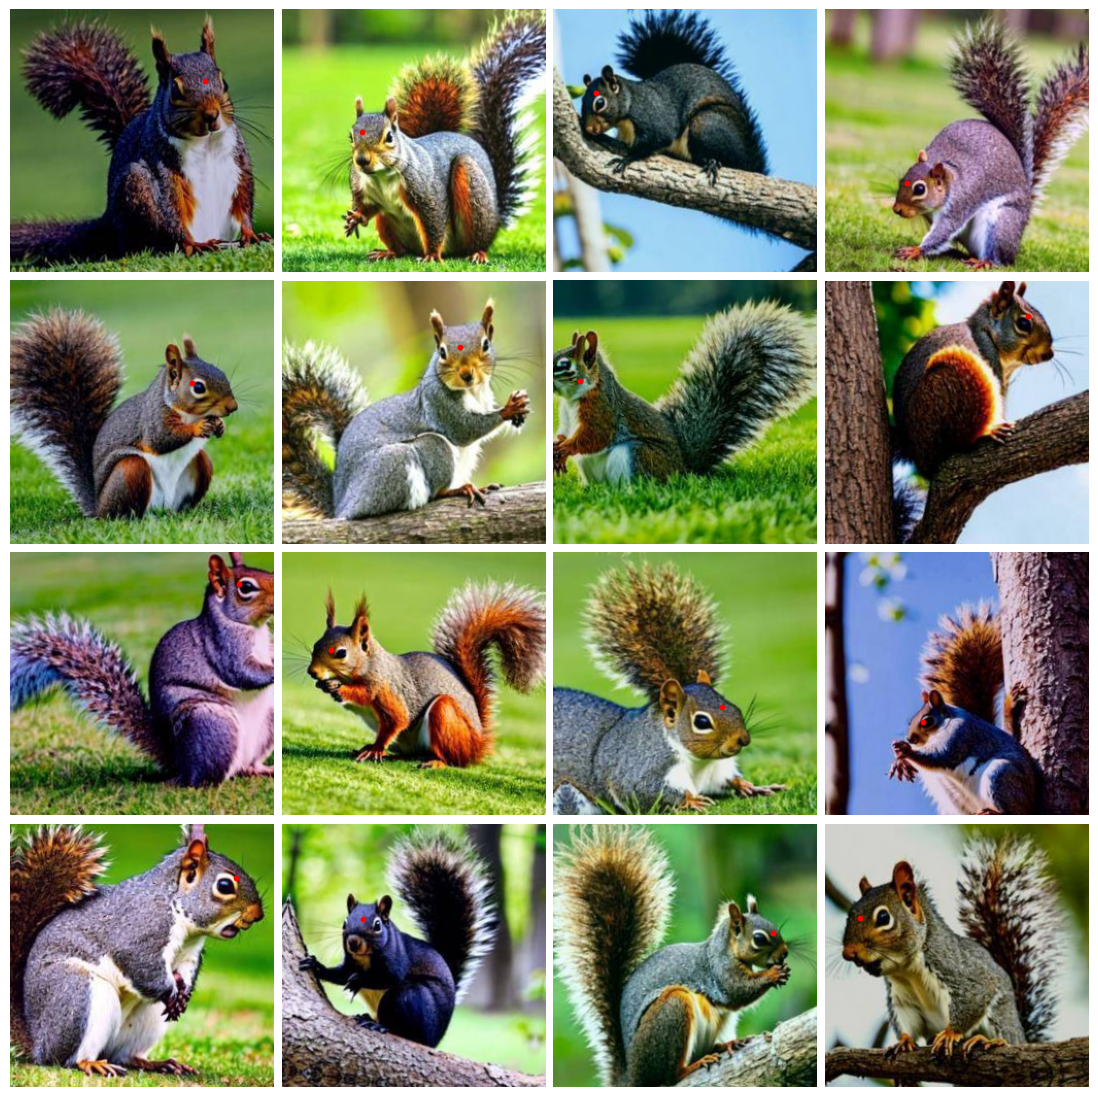

In [13]:
data = next(iterator)
visualize_batch(data[0]/255.0, data[1], size = 14, shape = (4, 4), title = 'Check Dataset and augmentation', save = False)